In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bss

plt.rcParams.update({'font.size': 14})

## Sparse matrix factorization: the GMCA example
The sources must verify two hypotheses.

<ins>First hypothesis</ins>: the sources are sparse in a given transformed domain (ie. most samples are zero-valued) 


For the sake of simplicity, we assume hereinbelow that the sources are sparse in the direct domain. 

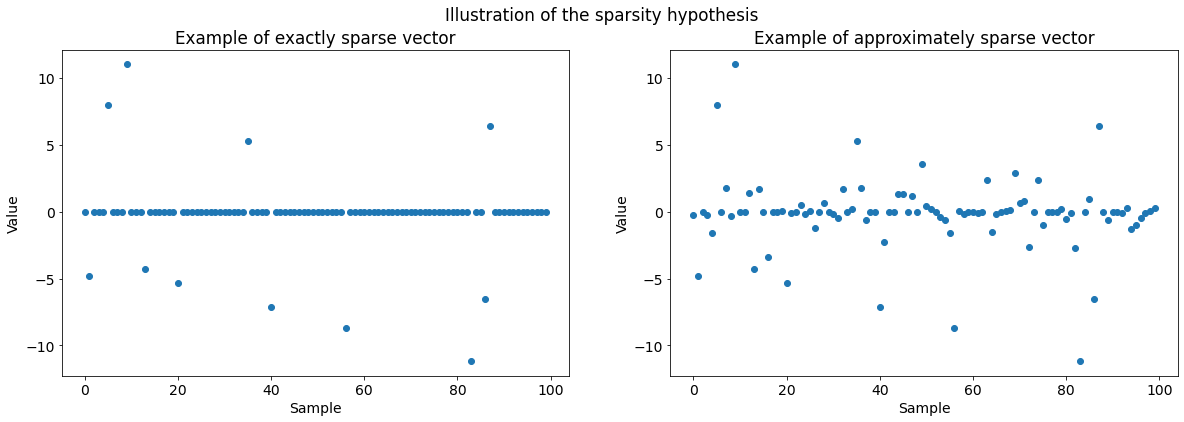

In [2]:
approx_sparse = np.random.randn(100)**3
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.suptitle('Illustration of the sparsity hypothesis')
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

<ins>Second hypothesis</ins>: the sources are morphologically diverse (ie. the non-zero samples of the sources are on different locations, in other words the supports of the sources are disjoint)

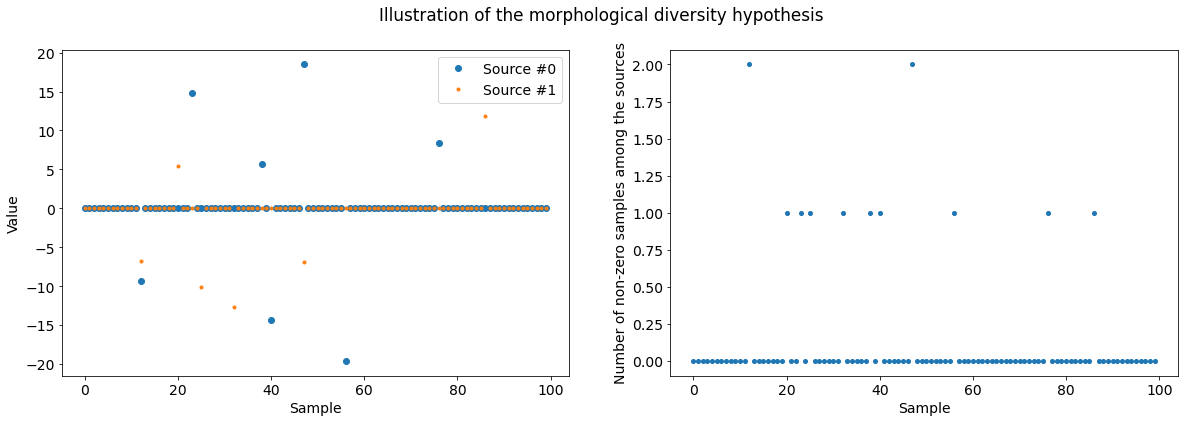

In [3]:
S = np.random.randn(2, 100)**3
S = S*(np.abs(S)>5)

fig = plt.figure(figsize=(20, 6))
plt.suptitle('Illustration of the morphological diversity hypothesis');
fig.add_subplot(1,2,1)
plt.plot(S[0, :], 'C0.', markerSize=12, label='Source #0')
plt.plot(S[1, :], 'C1.', markerSize=6, label='Source #1')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()

fig.add_subplot(1,2,2)
plt.plot(np.sum(S!=0, axis=0), '.', markerSize=8)
plt.xlabel('Sample')
plt.ylabel('Number of non-zero samples among the sources');

Let us generate the sources, mixing matrix and observations (with a 80 dB noise).

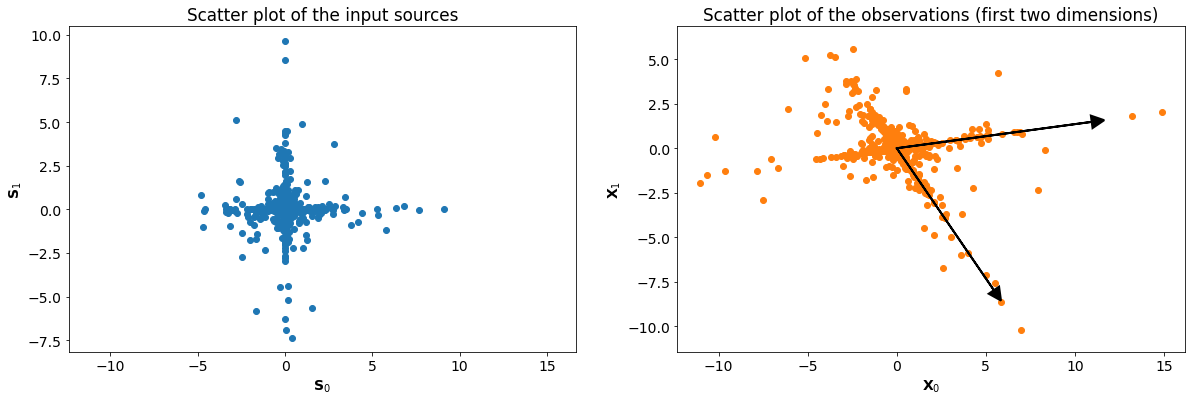

In [4]:
n = 2         # number of sources
m = 4         # number of observations
t = 1024      # number of samples

s_type = 3    # sparse sources

X, A, S = bss.makeMixture(s_type=s_type, n=n, m=m, t=t, noise_level=80)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

The GMCA algorithm aims at minimizing the following cost function:

$$\min\limits_{\mathbf{A}, \mathbf{S}} ||\mathbf{X}-\mathbf{AS}||_2 + \sum_{i=0}^{n} \lambda_i ||\mathbf{S}_i||_{0/1} $$

The resolution relies on an projected alternate least-square procedure. Iteratively:

1. Update of $\mathbf{S}$ with $\mathbf{A}$ fixed<br>
    1.1 Least-square update: $\mathbf{S} \leftarrow \mathbf{A}^+ \mathbf{X}$<br>
    1.2 Calculation of the thresholds: $\lambda_i = k~\text{mad}(\mathbf{S}_i)$<br>
    1.3 Thresholding: $\mathbf{S}_i \leftarrow \mathcal{T}_{\lambda_i}(\mathbf{S})$<br>


2. Update of $\mathbf{A}$ with $\mathbf{S}$ fixed<br>
    2.1 Least-square update: $\mathbf{A} \leftarrow \mathbf{X} \mathbf{S}^+$<br>
    2.2 Normalization: $\mathbf{A}^j \leftarrow \dfrac{\mathbf{A}^j}{||\mathbf{A}^j||_2}$<br>

The key point is the <b>thresholding</b>. It allows to keep the samples with the highest amplitudes, which are the most discrimative/informative to retrieve the mixing matrix. Indeed:
- due to the morphological assumption, they mostly belong to only one source,
- they are less affected by the noise.

The advantage of GMCA is to propose an <b>automatic and adaptative calculation of the thresholds</b>, using the median absolute deviator (mad). It can be showed that the resulting thresholds decrease along the iterations, which provides robustness in terms of convergence. 

Let us illustrate the estimated sources by GMCA along the iterations.

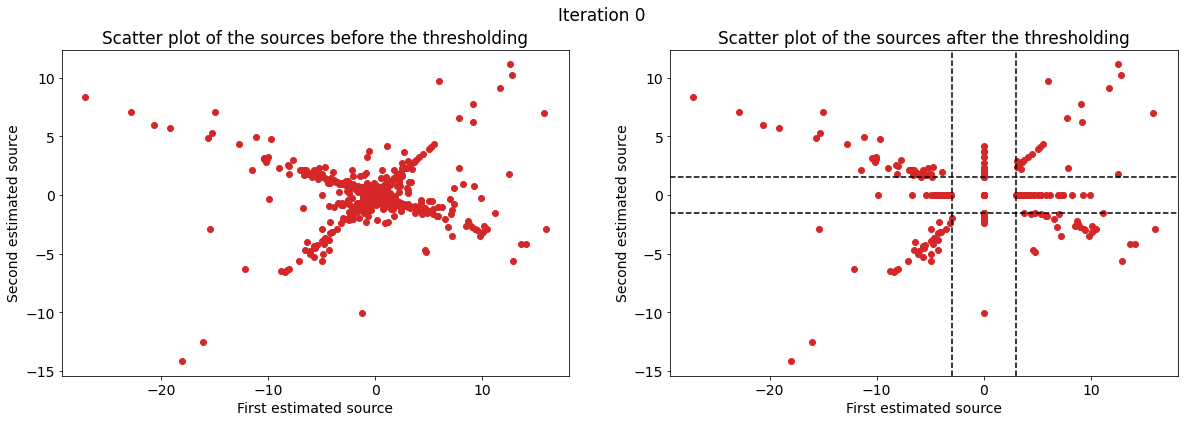

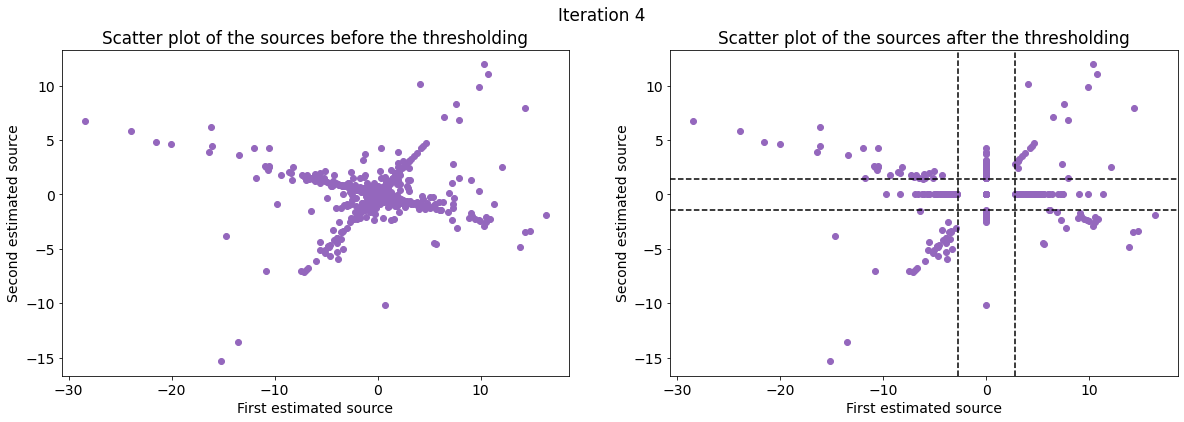

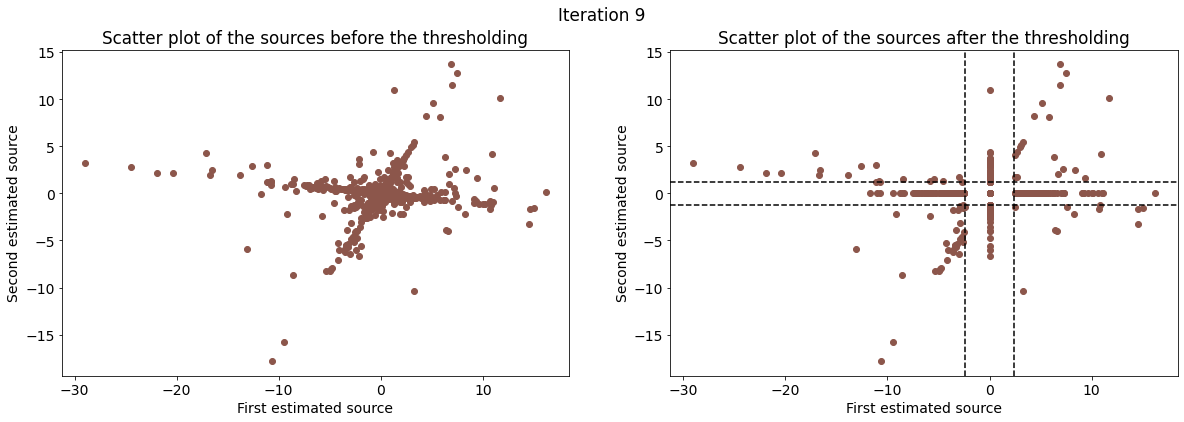

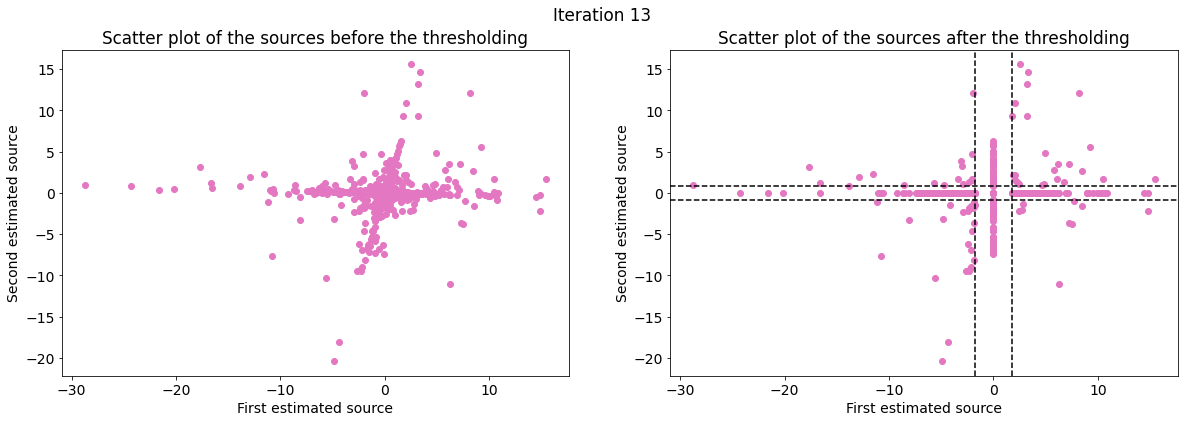

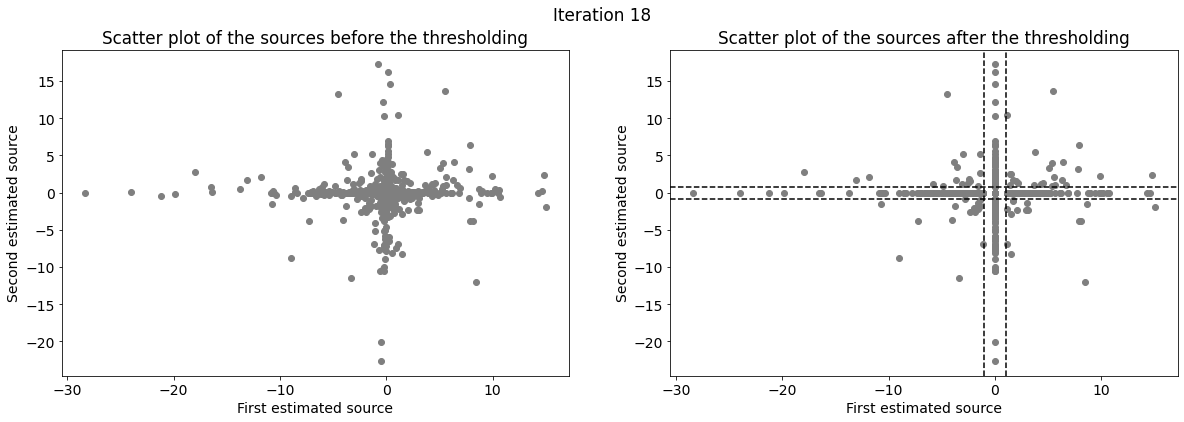

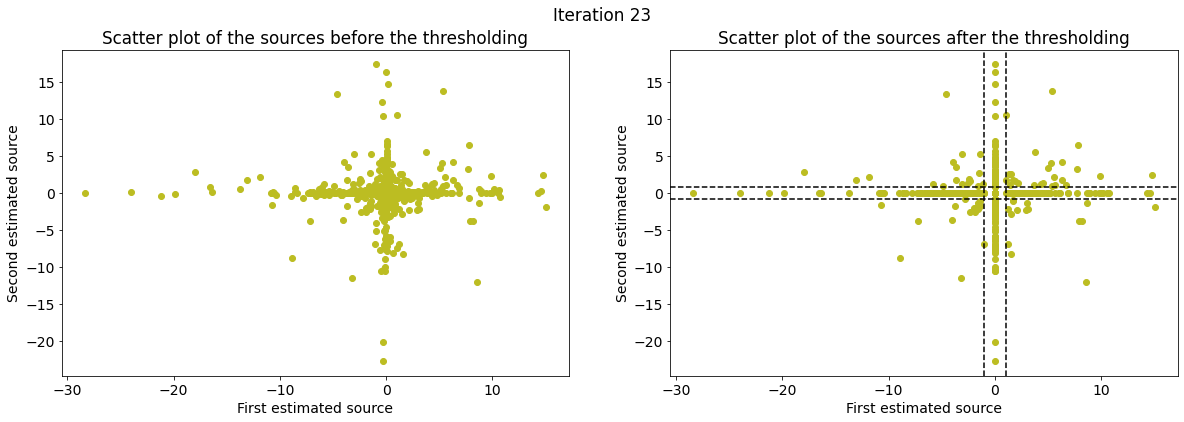

In [5]:
A_gmca, S_gmca, As_gmca, Ss_gmca, thrds = bss.gmca_getDetails(X, n)

i = 2
for it in np.linspace(0, np.shape(As_gmca)[0]-1, 6):
    it = np.int(it)
    i += 1
    fig = plt.figure(figsize=(20, 6))
    plt.suptitle('Iteration '+str(it))
    fig.add_subplot(1,2,1)
    plt.plot(Ss_gmca[it, 0, 0, :], Ss_gmca[it, 0, 1, :],'C'+str(i)+'o',zorder=0)
    plt.xlabel("First estimated source")
    plt.ylabel("Second estimated source")
    plt.title("Scatter plot of the sources before the thresholding");
    fig.add_subplot(1,2,2)
    plt.plot(Ss_gmca[it, 1, 0, :], Ss_gmca[it, 1, 1, :],'C'+str(i)+'o',zorder=0)
    plt.axhline(thrds[it, 1], color='k', linestyle='--')
    plt.axhline(-thrds[it, 1], color='k', linestyle='--')
    plt.axvline(thrds[it, 0], color='k', linestyle='--')
    plt.axvline(-thrds[it, 0], color='k', linestyle='--')
    plt.xlabel("First estimated source")
    plt.ylabel("Second estimated source")
    plt.title("Scatter plot of the sources after the thresholding");

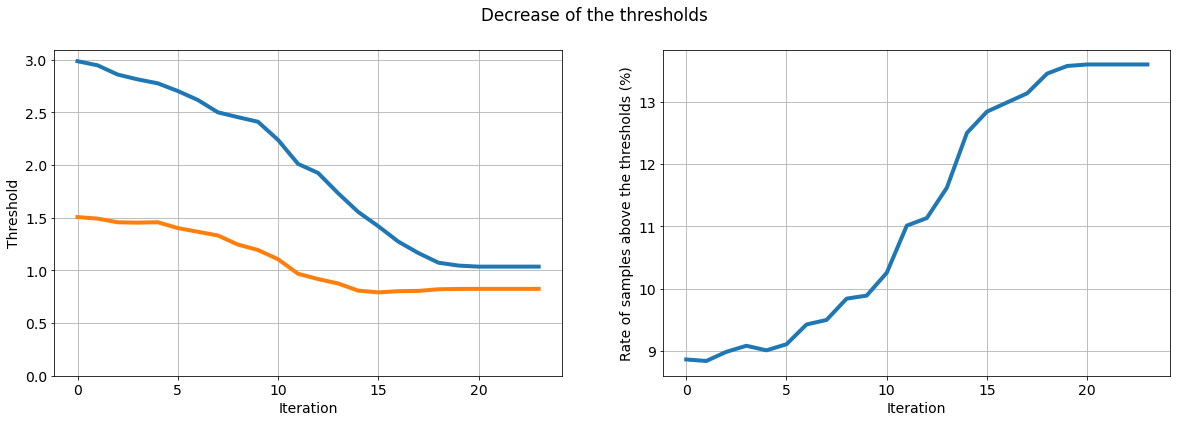

In [6]:
fig = plt.figure(figsize=(20, 6))
plt.suptitle('Decrease of the thresholds')
fig.add_subplot(1,2,1)
plt.plot(thrds[:, 0], linewidth=4)
plt.plot(thrds[:, 1], linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Threshold')
plt.grid()
plt.ylim(bottom=0);

fig.add_subplot(1,2,2)
plt.plot(np.sum(Ss_gmca[:, 1, :, :]!=0, axis=(1, 2))/(m*t)*100, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Rate of samples above the thresholds (%)')
plt.grid()

NMSE: 40.48 dB
CA: 23.10 dB


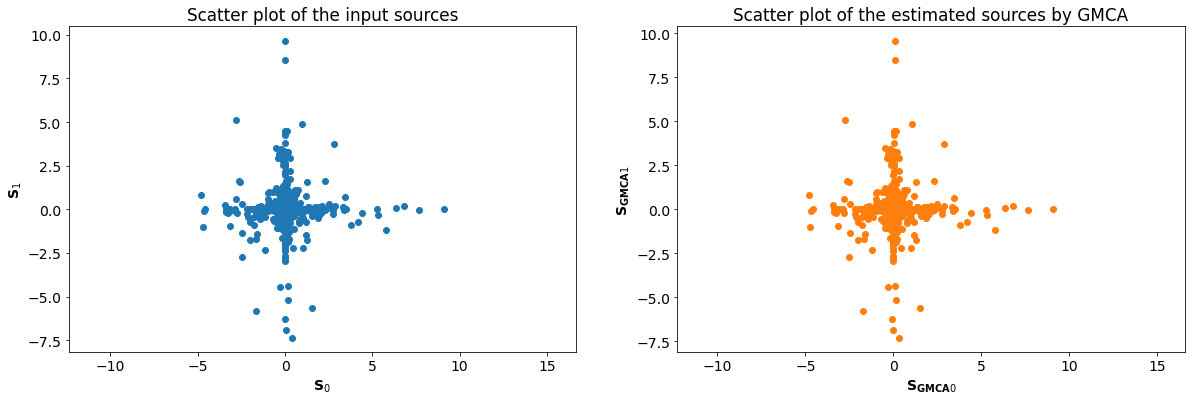

In [7]:
bss.corr_perm(A, S, A_gmca, S_gmca, inplace=True)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the estimated sources by GMCA')
plt.plot(S_gmca[0,:], S_gmca[1,:],'C1o',zorder=0)
plt.xlabel("$\mathbf{S_{GMCA}}_0$")
plt.ylabel("$\mathbf{S_{GMCA}}_1$");
plt.axis('equal');

print("NMSE: %.2f dB" % bss.nmse(S, S_gmca))
print("CA: %.2f dB" % bss.ca(A, A_gmca))

This is a basic version of GMCA. Some simple procedures allow to significantly improve the results...